In [3]:
!pip install re
!pip install nltk
!pip install unicodedata
!pip install contractions
!pip install inflect
!pip install emoji
!pip install typing_extensions==4.7.1
!pip install seaborn
!pip install hdbscan

Looking in indexes: https://pypi.python.org/simple/
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
Looking in indexes: https://pypi.python.org/simple/
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.8.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.8.3-cp39-cp39-manylinux_2_17_x86_64.manylinux201

# Import

In [2]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import re
from sklearn.model_selection import train_test_split
import torch
import re
import nltk
import emoji
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
import unicodedata
import contractions
import hdbscan
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from numpy import dot
from numpy.linalg import norm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.notebook import tqdm

# Data

In [12]:
#books_rating = pd.read_csv("data/Books_rating.csv")

In [13]:
#df_books_rating = books_rating.sample(n=10000)
#df_books_rating.to_csv("df_books_rating.csv", index=False)

In [3]:
df_books_rating = pd.read_csv("df_books_rating.csv")

## EDA

In [27]:
df_books_rating['review/score'].unique()

array([4., 5., 3., 2., 1.])

In [48]:
dict_len_unique = {}
length_uniq = []
values_uniq = []
n = 1000
for score in list(df_books_rating['review/score'].unique()): 
    length_uniq += list(books_rating[books_rating['review/score'] == score]['review/text'].sample(n=n).apply(lambda x: len(x)))
    values_uniq += [str(score)]*n
dict_len_unique['len'] = length_uniq
dict_len_unique['score'] = values_uniq
df_len_unique = pd.DataFrame(data=dict_len_unique)

In [49]:
df_len_unique.head()

,len,score
0,2146,4.0
1,1186,4.0
2,161,4.0
3,759,4.0
4,180,4.0


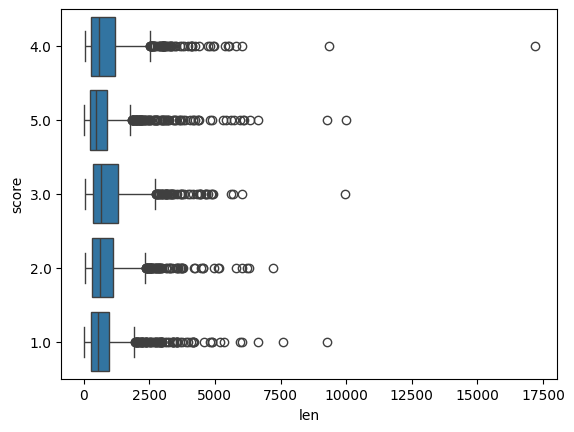

In [50]:
sns.boxplot(data=df_len_unique, x="len", y="score")
plt.draw()

model_id - mistralai/Mistral-7B-Instruct-v0.2
mean - 192.3182
median - 123.0



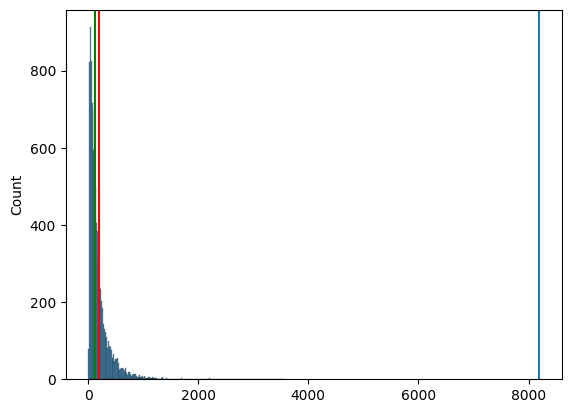

In [8]:
def get_count_tokens(tokenizer, text: str):
    return len(tokenizer(text)['input_ids'])

model_name = 'mistralai/Mistral-7B-Instruct-v0.2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
context_length = 8192

tokens_text = np.array(df_books_rating['review/text'].apply(lambda x: get_count_tokens(tokenizer, x)))

mean, median = np.mean(tokens_text), np.median(tokens_text)
print(f"model_id - {model_name}")
print(f"mean - {mean}")
print(f"median - {median}")
print()

sns.histplot(x=tokens_text)
plt.axvline(x=mean, color='red')
plt.axvline(x=median, color='green')
plt.axvline(x=context_length)
plt.draw()

# Methods

## Method 1 - TF-IDF & KMeans

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

class Vectorizer:
    """
    Класс для векторизации текстовых данных с использованием метода TF-IDF.
    
    Этот класс предоставляет функциональность для векторизации как отдельных текстов, так и корпуса документов.
    Основан на использовании TfidfVectorizer из библиотеки scikit-learn.
    
    Атрибуты:
        sentence_vectorizer (TfidfVectorizer): Векторизатор для обработки отдельных текстов.
        corpus_vectorizer (TfidfVectorizer): Векторизатор для обработки корпуса документов.
        
    Методы:
        __init__(self): Инициализирует экземпляр класса, создавая два экземпляра TfidfVectorizer.
        
        corpus_fit_vectorize(self, corpus: list[str]): Производит подготовку векторизатора корпуса к работе с переданным корпусом документов.
        
        corpus_transform_vectorize(self, input_text: list[str]): Преобразует предоставленные тексты в разреженную матрицу признаков TF-IDF, используя ранее подготовленный векторизатор корпуса.
        
        text_vectorize(self, input_text: list[str]): Векторизует отдельные тексты или предложения, преобразуя их в матрицу признаков TF-IDF с помощью векторизатора для отдельных текстов. Подходит для разовых задач векторизации текста, где процесс подготовки не отделён от преобразования.
    """
    def __init__(self):
        """
        Инициализация векторизатора.
        Создает два экземпляра TfidfVectorizer: один для работы с отдельными текстами, другой — для работы с корпусом документов.
        """
        self.sentence_vectorizer = TfidfVectorizer()
        self.corpus_vectorizer = TfidfVectorizer()
    
    def corpus_fit_vectorize(self, corpus: list[str]):
        """
        Подготавливает векторизатор корпуса к работе с переданным корпусом документов.
        
        Параметры:
            corpus (list[str]): Список строк, где каждая строка представляет собой документ в корпусе.
            
        Возвращает:
            None
        """
        self.corpus_vectorizer.fit(corpus)
        
    def corpus_transform_vectorize(self, input_text: list[str]):
        """
        Преобразует предоставленные тексты в разреженную матрицу признаков TF-IDF.
        
        Параметры:
            input_text (list[str]): Список строк для векторизации. Это могут быть новые документы, не участвующие в процессе подготовки.
            
        Возвращает:
            scipy.sparse.csr.csr_matrix: Разреженная матрица признаков TF-IDF предоставленных текстов.
        """
        counts_matrix = self.corpus_vectorizer.transform(input_text)
        return counts_matrix
        
    def text_vectorize(self, input_text: list[str]) -> np.array:
        """
        Векторизует отдельные тексты или предложения.
        
        Параметры:
            input_text (list[str]): Список строк, где каждая строка - это текст или предложение для векторизации.
            
        Возвращает:
            np.ndarray: Массив numpy, содержащий плотное представление признаков TF-IDF входных текстов.
        """
        # Использование vectorizer.fit_transform для преобразования текста
        counts_matrix = self.sentence_vectorizer.fit_transform(input_text)
        
        # Преобразование полученной матрицы в плотную матрицу
        dense_matrix = counts_matrix.todense()
        
        # Возврат плотной матрицы в виде массива numpy 
        return np.array(dense_matrix)
    
class Similarity:
    """
    Класс для вычисления сходства между векторами.
    
    Этот класс предоставляет методы для вычисления косинусного сходства и сходства на основе TF-IDF между двумя векторами.
    
    Методы:
        calc_cos_sim(self, a: np.array, b: np.array): Вычисляет косинусное сходство между двумя векторами.
        
        calc_tfidf_sim(self, a: np.array, b: np.array): Вычисляет сходство на основе TF-IDF между средними значениями двух векторов.
        
    Примеры использования:
        similarity = Similarity()
        vector_a = np.array([1, 2, 3])
        vector_b = np.array([4, 5, 6])
        
        cos_sim = similarity.calc_cos_sim(vector_a, vector_b)
        print(f"Косинусное сходство: {cos_sim}")
        
        tfidf_sim = similarity.calc_tfidf_sim(vector_a, vector_b)
        print(f"Сходство TF-IDF: {tfidf_sim}")
    """

    def calc_cos_sim(self, a: np.array, b: np.array):
        """
        Вычисляет косинусное сходство между двумя векторами.
        
        Параметры:
            a (np.array): Первый вектор.
            b (np.array): Второй вектор.
            
        Возвращает:
            float: Косинусное сходство между векторами a и b, округленное до двух знаков после запятой.
        """
        cos_sim = dot(a, b) / (norm(a) * norm(b) + 0.000001)
        return np.round(cos_sim, 2)
    
    def calc_tfidf_sim(self, a: np.array, b: np.array):
        """
        Вычисляет сходство на основе TF-IDF между средними значениями двух векторов.
        
        Параметры:
            a (np.array): Первый вектор.
            b (np.array): Второй вектор.
            
        Возвращает:
            float: Сходство на основе TF-IDF между средними значениями векторов a и b, округленное до двух знаков после запятой.
            
        Примечание:
            Этот метод не является стандартным способом вычисления сходства на основе TF-IDF и представлен для демонстрации.
        """
        return np.round(b.mean() / a.mean(), 2)

class Cleaner:
    """
    Класс Cleaner предназначен для предварительной обработки текста перед его анализом.
    Он включает в себя функции для удаления HTML-тегов, URL, эмоджи, специальных символов,
    преобразования чисел в слова, удаления стоп-слов и знаков препинания, а также лемматизации.
    
    Методы:
        clean_text(self, input_text): Очищает входной текст от различных нежелательных элементов и приводит его к стандартному виду.
        
        emojis_words(self, text): Преобразует эмоджи в слова, используя их текстовое описание.
        
        remove_noise_boilerplate(self, vectorizer, input_text, min_cluster_size=2, num_clusters=3, max_noise_ratio=0.3):
            Функция для удаления шума и шаблонных фраз из текста. Параметры vectorizer, min_cluster_size, num_clusters и max_noise_ratio
            используются для настройки процесса очистки. (Функция не реализована в данном примере)
    
    Пример использования:
        cleaner = Cleaner()
        raw_text = "Some raw text with HTML <html>...</html>, URLs http://example.com, and emojis 😊."
        clean_text = cleaner.clean_text(raw_text)
        print(clean_text)
    """

    def __init__(self):
        """
        Инициализирует экземпляр класса Cleaner, загружая необходимые ресурсы для лемматизации и токенизации.
        """

        self.model_lemmatizer = WordNetLemmatizer()
        self.tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        
    # Функция для очистки текста
    def clean_text(self, input_text):  
        """
        Очищает входной текст от HTML-тегов, URL, эмоджи, специальных символов,
        преобразует числа в слова, удаляет стоп-слова и знаки препинания, и проводит лемматизацию.

        Параметры:
            input_text (str): Входной текст для очистки.

        Возвращает:
            str: Очищенный текст.
        """
        
        # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
        clean_text = re.sub('<[^<]+?>', '', input_text)

        # URL и ссылки: далее - удаляем из текста все URL и ссылки
        clean_text = re.sub(r'http\S+', '', clean_text)

        # Эмоджи и эмотиконы: используем собственную функцию для преобразования эмоджи в текст
        # Важно понимать эмоциональную окраску обрабатываемого текста
        clean_text = self.emojis_words(clean_text)

        # Приводим все входные данные к нижнему регистру
        clean_text = clean_text.lower()

        # Убираем все пробелы
        # Так как все данные теперь представлены словами - удалим пробелы
        clean_text = re.sub('\s+', ' ', clean_text)

        # Преобразование символов с диакритическими знаками к ASCII-символам: используем функцию normalize из модуля unicodedata и преобразуем символы с диакритическими знаками к ASCII-символам
        clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # Разворачиваем сокращения: текст часто содержит конструкции вроде "don't" или "won't", поэтому развернём подобные сокращения
        clean_text = contractions.fix(clean_text)

        # Убираем специальные символы: избавляемся от всего, что не является "словами"
        clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

        # Записываем числа прописью: 100 превращается в "сто" (для компьютера)
        temp = inflect.engine()
        words = []
        for word in clean_text.split():
            if word.isdigit():
                words.append(temp.number_to_words(word))
            else:
                words.append(word)
        clean_text = ' '.join(words)

        # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(clean_text)
        tokens = [token for token in tokens if token not in stop_words]
        clean_text = ' '.join(tokens)

        # Знаки препинания: далее - удаляем из текста все знаки препинания
        clean_text = re.sub(r'[^\w\s]', '', clean_text)
        
        # лемматизируем каждое слово
        clean_text = ' '.join([self.model_lemmatizer.lemmatize(w) for w in clean_text.split(' ')])
        # И наконец - возвращаем очищенный текст
        return clean_text

    # Функция для преобразования эмоджи в слова
    def emojis_words(self, text):
        """
        Преобразует эмоджи в тексте в их словесные описания.

        Параметры:
            text (str): Текст для преобразования эмоджи.

        Возвращает:
            str: Текст с преобразованными эмоджи.
        """
        # Модуль emoji: преобразование эмоджи в их словесные описания
        clean_text = emoji.demojize(text, delimiters=(" ", " "))

        # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
        clean_text = clean_text.replace(":", "").replace("_", " ")

        return clean_text
    
    def remove_noise_boilerplate(self, 
                                 vectorizer: Vectorizer, 
                                 input_text: str, 
                                 min_cluster_size: int = 2, 
                                 num_clusters: int = 3, 
                                 max_noise_ratio: float = 0.3):
        """
        Функция для удаления шума и шаблонных фраз из текста. Данная функция требует дополнительной реализации.

        Параметры:
            vectorizer: Векторизатор для преобразования текста в числовые векторы.
            input_text (str): Входной текст для очистки.
            min_cluster_size (int): Минимальный размер кластера для анализа.
            num_clusters (int): Количество кластеров для анализа.
            max_noise_ratio (float): Максимально допустимое соотношение шума.

        Возвращает:
            Тип возвращаемого значения не указан из-за отсутствия реализации.
        """

        # Разбиение текста на предложения: для идентификации шаблонных фрагментов или "шума" сначала надо выделить из текста предложения, которые мы будем сравнивать друг с другом
        sentences = self.tokenizer.tokenize(input_text)
        
        # для маленьких текстов указываю num_clusters, которая равняется кол-ву предложений
        if len(sentences) <= num_clusters:
            num_clusters = len(sentences)
        # для средних текстов указываю num_clusters, которая равняется трём
        elif len(sentences) < 12:
            num_clusters = 3
        # для средних текстов указываю num_clusters, которая равняется кол-ву предложений делённых на 4
        else:
            num_clusters = int(len(sentences)/4)
            max_noise_ratio += 0.1
        
        # Преобразование предложений в матрицу словесных эмбеддингов
        embeddings_matrix = vectorizer.text_vectorize(sentences)

        # KMean-кластеризация: кластеризация предложений, позволяющая разместить похожие эмбеддинги поблизости друг от друга 
        kmeans_model = KMeans(n_clusters=num_clusters)
        kmeans_model.fit(embeddings_matrix)
        model_labels = kmeans_model.labels_
        model_centroids = kmeans_model.cluster_centers_
        cluster_sizes = np.bincount(model_labels)

        # Идентификация кластеров, содержащих "шум" и шаблонные формулировки
        is_noise = np.zeros(num_clusters, dtype=bool)
        for i, centroid in enumerate(model_centroids):
            if cluster_sizes[i] < min_cluster_size:
                # Игнорируем кластеры, количество предложений в которых меньше, чем пороговое значение - min_cluster_size
                continue
            distances = np.linalg.norm(embeddings_matrix[model_labels == i] - centroid, axis=1)
            median_distance = np.median(distances)
            if np.count_nonzero(distances > median_distance) / cluster_sizes[i] > max_noise_ratio:
                is_noise[i] = True

        # Удаление ненужных данных: предложения, которые идентифицированы как "шум" или шаблонный текст, удаляются
        filtered_sentences = []
        for i, sentence in enumerate(sentences):
            if not is_noise[model_labels[i]]:
                filtered_sentences.append(sentence)

        filtered_text = ' '.join(filtered_sentences)
        return filtered_text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
class QualityEvaluater:
    """
    Класс QualityEvaluater предназначен для оценки качества текста на основе различных метрик, таких как
    косинусное сходство, TF-IDF сходство и стандартизированное TF-IDF значение. Он использует предварительную
    обработку текста, векторизацию и вычисление сходства для оценки текстов.

    Атрибуты:
        cleaner (Cleaner): Экземпляр класса Cleaner для предварительной обработки текста.
        vectorizer (Vectorizer): Экземпляр класса Vectorizer для преобразования текста в векторное представление.
        similarity (Similarity): Экземпляр класса Similarity для вычисления метрик сходства между векторами.
        corpus (list[str]): Список строк, представляющий корпус текстов для анализа.
        cleaned_corpus (list[str]): Список предварительно обработанных строк корпуса.
        max_length (int): Максимальная длина текста в cleaned_corpus.

    Методы:
        get_cleaned_text(text: str) -> list:
            Возвращает очищенный нежелательных элементов текст.

        get_unnoised_text(text: str) -> list:
            Возвращает текст, очищенный от шаблонных фраз и шума.

        get_embeddings(text: str):
            Возвращает векторные представления для очищенного текста и текста, очищенного от шума.

        get_score_cos_sim(text: str) -> float:
            Возвращает оценку косинусного сходства между векторными представлениями очищенного текста и текста без шума.

        get_score_tfidf(text: str) -> float:
            Возвращает оценку сходства на основе TF-IDF между векторными представлениями очищенного текста и текста без шума.

        get_score_standarted_tfidf(text: str) -> float:
            Возвращает стандартизированное значение TF-IDF для векторного представления очищенного текста.

        get_length(text: str) -> int:
            Возвращает относительную длину очищенного текста по отношению к максимальной длине текста в корпусе.
    
    Пример использования:
        # Предполагается, что классы Cleaner, Vectorizer и Similarity уже реализованы.
        cleaner = Cleaner()
        vectorizer = Vectorizer()
        similarity = Similarity()
        corpus = ["Пример текста.", "Ещё один пример текста."]
        
        evaluater = QualityEvaluater(cleaner, vectorizer, similarity, corpus)
        
        text = "Текст для оценки."
        score_cos_sim = evaluater.get_score_cos_sim(text)
        print(f"Оценка косинусного сходства: {score_cos_sim}")
        
        score_tfidf = evaluater.get_score_tfidf(text)
        print(f"Оценка TF-IDF сходства: {score_tfidf}")
        
        score_standarted_tfidf = evaluater.get_score_standarted_tfidf(text)
        print(f"Стандартизированное значение TF-IDF: {score_standarted_tfidf}")
        
        length_ratio = evaluater.get_length(text)
        print(f"Относительная длина текста: {length_ratio}")
    """

    def __init__(self, 
                 cleaner: Cleaner, 
                 vectorizer: Vectorizer, 
                 similarity: Similarity, 
                 corpus: list[str]):
        """
        Инициализирует экземпляр класса QualityEvaluater.

        Аргументы:
            cleaner (Cleaner): Экземпляр класса для очистки текста.
            vectorizer (Vectorizer): Экземпляр класса для векторизации текста.
            similarity (Similarity): Экземпляр класса для вычисления мер сходства между текстами.
            corpus (list[str]): Список текстов, который будет использоваться как корпус для анализа.

        В процессе инициализации происходит предварительная обработка корпуса текстов, его векторизация
        и определение максимальной длины текста в корпусе.
        """

        self.cleaner = cleaner
        self.vectorizer = vectorizer
        self.similarity = similarity
        self.cleaned_corpus = [self.cleaner.clean_text(item) for item in corpus]
        self.vectorizer.corpus_fit_vectorize(self.cleaned_corpus)
        self.max_length = max([len(text) for text in self.cleaned_corpus])
    
    def get_cleaned_text(self, text: str) -> list:
        """
        Возвращает очищенный от шума и нежелательных элементов текст.

        Аргументы:
            text (str): Исходный текст для очистки.

        Возвращает:
            list: Очищенный текст в виде списка токенов.
        """

        cleaned_text = self.cleaner.clean_text(text)
        return cleaned_text
    
    def get_unnoised_text(self, text: str) -> list:
        """
        Возвращает текст, очищенный от шаблонных фраз и шума.

        Аргументы:
            text (str): Исходный текст для очистки.

        Возвращает:
            list: Текст после удаления шаблонных фраз и шума в виде списка токенов.
        """

        unnoised_text = self.cleaner.remove_noise_boilerplate(vectorizer=self.vectorizer, input_text=text)
        return unnoised_text
    
    def get_embeddings(self, text: str):
        """
        Возвращает векторные представления для очищенного текста и текста, очищенного от шума.

        Аргументы:
            text (str): Исходный текст для получения векторных представлений.

        Возвращает:
            tuple: Кортеж из двух numpy массивов, представляющих векторные представления очищенного текста и текста без шума.
        """

        cleaned_text = self.get_cleaned_text(text)
        unnoised_text = self.get_unnoised_text(text)
        cleand_unnoised_text = self.get_cleaned_text(unnoised_text)
        
        vector_cleaned_text = self.vectorizer.corpus_transform_vectorize([cleaned_text])
        vector_cleand_unnoised_text = self.vectorizer.corpus_transform_vectorize([cleand_unnoised_text])
        
        a = np.array(vector_cleaned_text.todense())[0]
        b = np.array(vector_cleand_unnoised_text.todense())[0]
        
        return a, b
    
    def get_score_cos_sim(self, text: str) -> float:
        """
        Возвращает оценку косинусного сходства между векторными представлениями очищенного текста и текста без шума.

        Аргументы:
            text (str): Исходный текст для оценки.

        Возвращает:
            float: Значение косинусного сходства между двумя векторными представлениями текста.
        """

        a, b = self.get_embeddings(text)
        return self.similarity.calc_cos_sim(a, b)
    
    def get_score_tfidf(self, text: str) -> float:
        """
        Возвращает оценку сходства на основе TF-IDF между векторными представлениями очищенного текста и текста без шума.

        Аргументы:
            text (str): Исходный текст для оценки.

        Возвращает:
            float: Значение сходства на основе TF-IDF между двумя векторными представлениями текста.
        """

        a, b = self.get_embeddings(text)
        return self.similarity.calc_tfidf_sim(a, b)
    
    def get_score_standarted_tfidf(self, text: str) -> float:
        """
        Возвращает стандартизированное значение TF-IDF для векторного представления очищенного текста.

        Аргументы:
            text (str): Исходный текст для оценки.

        Возвращает:
            float: Стандартизированное значение TF-IDF для векторного представления текста.
        """
        cleaned_text = self.get_cleaned_text(text)
        vector_cleaned_text = self.vectorizer.corpus_transform_vectorize([cleaned_text])
        vector_cleaned_text = np.array(vector_cleaned_text.todense())[0]
        return vector_cleaned_text.mean()/vector_cleaned_text.max()
    
    def get_length(self, text: str) -> int:
        """
        Возвращает относительную длину очищенного текста по отношению к максимальной длине текста в корпусе.

        Аргументы:
            text (str): Исходный текст для определения его длины.

        Возвращает:
            int: Относительная длина очищенного текста.
        """

        cleaned_text = self.get_cleaned_text(text)
        return len(cleaned_text)/self.max_length

## Method 2 - G-Eval

In [5]:
TEMPLATE_PROMPT = """
You will be given a review of the book.
Your task is to evaluate the content of the book review.
Please make sure that you have read and understood this review carefully.
Please keep this document in mind during the assessment and refer to it if necessary. 
The score can be from 1 to 5.
The content (1-5) is the degree of its informativeness, reasonableness and depth of analysis of the content of the work. A meaningful review contributes to a deeper understanding of the book and helps other readers make an informed decision about reading it.
Rating 1 is not a meaningful review that does not provide any information about the book, a superficial impression without argumentation.
Score 2 is The minimum content. The review contains a limited amount of information about the book, but the reasoning is insufficient or inconclusive.
Score 3 - Satisfactory content. The review provides basic information about the book and contains some arguments or impressions, but may not be deep enough or thorough enough.
Score 4 - High content. The review contains extensive information about the book, well-developed arguments and an analysis of the main aspects of the work.
Score 5 - Excellent content. The review is a complete, informative and in-depth analysis of the book, providing readers with an extensive understanding of its content, structure and significance.
In the answer, write only the number, only 1, 2, 3, 4 or 5 without explanations and unnecessary words.

Steps in evaluating the content of a book review:
1. Read the review carefully to understand the author's perspective and arguments.
2. Analyze the amount and quality of information the review provides about the book.
3. Assess the reasoning behind the review and its depth of analysis.
4. Determine the overall contribution of the review to the reader's understanding of the book.
5. Based on the analysis, assign a score between 1 and 5.


Review: {review}
Score (write only 1, 2, 3, 4, or 5):
"""

class GEval:
    """
    Класс GEval предназначен для оценки сгенерированного текста с использованием предобученной языковой модели.
    
    Атрибуты:
        model (AutoModelForCausalLM): Экземпляр предобученной языковой модели для генерации текста.
        tokenizer (AutoTokenizer): Токенизатор, соответствующий модели, для преобразования текста в токены и обратно.
        score_tokens (list[int]): Список идентификаторов токенов, используемых для оценки сгенерированного текста.
        weight_tokens (torch.tensor): Веса, соответствующие токенам оценок, для вычисления итогового балла.
        
    Методы:
        init(self, model_name: str):
            Инициализирует экземпляр класса, загружая модель и токенизатор по указанному имени модели.
            
        find_tokens(self, generated_tokens: list, score_tokens: list) -> list:
            Возвращает индексы токенов из списка generated_tokens, которые присутствуют в списке score_tokens.
            
        predict(self, review: str) -> float:
            Генерирует продолжение текста на основе входного примера review и вычисляет итоговый балл сгенерированного текста.
    
    Пример использования:
        # Инициализация оценщика с предобученной моделью
        g_eval = GEval('gpt2')
        
        # Оценка сгенерированного текста
        score = g_eval.predict("Пример текста для генерации.")
        
        print(f"Итоговый балл: {score}")
    """

    def __init__(self, model_name: str):
        """
        Инициализирует экземпляр класса GEval.
        
        Аргументы:
            model_name (str): Имя предобученной модели, которая будет использоваться для генерации текста.
        """

        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.score_tokens = self.tokenizer.convert_tokens_to_ids(['1', '2', '3', '4', '5'])
        self.weight_tokens = torch.tensor([1., 2., 3., 4., 5.])
        
    def find_tokens(self, generated_tokens: list, score_tokens: list):
        """
        Находит индексы токенов из списка score_tokens в списке generated_tokens.
        
        Аргументы:
            generated_tokens (list): Список идентификаторов сгенерированных токенов.
            score_tokens (list): Список идентификаторов токенов оценок.
        
        Возвращает:
            list: Список индексов токенов оценок в сгенерированном тексте.
        """

        indexies = []
        for i in range(len(generated_tokens)):
            id_token = generated_tokens[i]
            for id_score_token in score_tokens:
                if id_token == id_score_token:
                    indexies.append(i)
        return indexies
        
    def predict(self, review: str) -> float:
        """
        Генерирует продолжение текста на основе входного примера и вычисляет итоговый балл сгенерированного текста.
        
        Аргументы:
            review (str): Текст, на основе которого будет сгенерировано продолжение.
        
        Возвращает:
            float: Итоговый балл сгенерированного текста.
        """

        prompt = TEMPLATE_PROMPT.format(review=review)
        
        messages = [
            {"role": "user", "content": prompt}
        ]
        
        encodeds = self.tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to(self.model.device)
        
        generation = self.model.generate(model_inputs, 
                               max_new_tokens=25, 
                               pad_token_id=self.tokenizer.eos_token_id,
                               output_scores=True,
                               return_dict_in_generate=True,
                               do_sample=False)
        
        generated_ids = generation['sequences']
        all_logits = generation['scores']
        generated_tokens = generated_ids[:, len(model_inputs[0]):][0].tolist()
        decoded = self.tokenizer.batch_decode(generated_ids)
        ids = self.find_tokens(generated_tokens, self.score_tokens)
        try:
            logits_token = all_logits[ids[0] - 1][0]
        except:
            logits_token = all_logits[-1]
            
        log_probs = torch.nn.functional.softmax(logits_token[self.score_tokens], dim=0).detach().cpu()
        score = torch.dot(log_probs, self.weight_tokens).item()
        return score

# Comprasion of Methods

### Data

In [15]:
#train_corpus, test_corpus = train_test_split(df_books_rating['review/text'], 
#                                             train_size=0.9, 
#                                             random_state=42)
#train_corpus.to_csv('train_corpus.csv', index=False)
#test_corpus.to_csv('test_corpus.csv', index=False)

In [16]:
train_corpus = list(pd.read_csv('train_corpus.csv')['review/text'])
test_corpus = list(pd.read_csv('test_corpus.csv')['review/text'])

### Method 1 - TF-IDF & KNN

In [17]:
cleaner = Cleaner()
vectorizer = Vectorizer()
similarity = Similarity()

In [18]:
quality_evaluater = QualityEvaluater(cleaner=cleaner, 
                                     vectorizer=vectorizer, 
                                     similarity=similarity, 
                                     corpus=train_corpus)

In [19]:
score_lst, type_lst, id_lst = [], [], []
cos_sim_lst, tfidf_lst, tfidf_standart_lst, length_lst = [], [], [], []
for i in tqdm(range(len(test_corpus))):
    text = test_corpus[i]
    cos_sim_value = quality_evaluater.get_score_cos_sim(text)
    tfidf_value = quality_evaluater.get_score_tfidf(text)
    tfidf_standart_value = quality_evaluater.get_score_standarted_tfidf(text)
    length_value = quality_evaluater.get_length(text)
    
    cos_sim_lst.append(cos_sim_value)
    tfidf_lst.append(tfidf_value)
    tfidf_standart_lst.append(tfidf_standart_value)
    length_lst.append(length_value)
    
    score_lst += [cos_sim_value, tfidf_value, tfidf_standart_value, length_value]
    type_lst += ['cos_sim', 'tfidf', 'tfidf_standart', 'length']
    id_lst += [str(i), str(i), str(i), str(i)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
dct_score = {"score": score_lst, "type": type_lst, "index": id_lst}
df_score = pd.DataFrame(data=dct_score)

In [21]:
df_score.to_csv('df_score_tfidf_knn.csv', index=False)

In [22]:
df_score.head()

,score,type,index
0,0.590000,cos_sim,0
1,0.640000,tfidf,0
2,0.000364,tfidf_standart,0
3,0.058472,length,0
4,0.350000,cos_sim,1


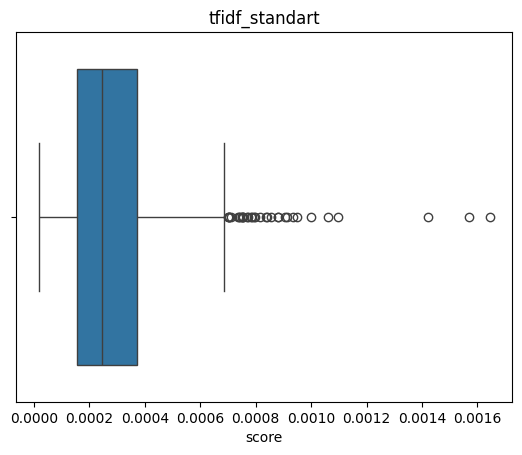

In [27]:
sns.boxplot(data=df_score[df_score['type'] == 'tfidf_standart'], x="score")
plt.title("tfidf_standart")
plt.draw()

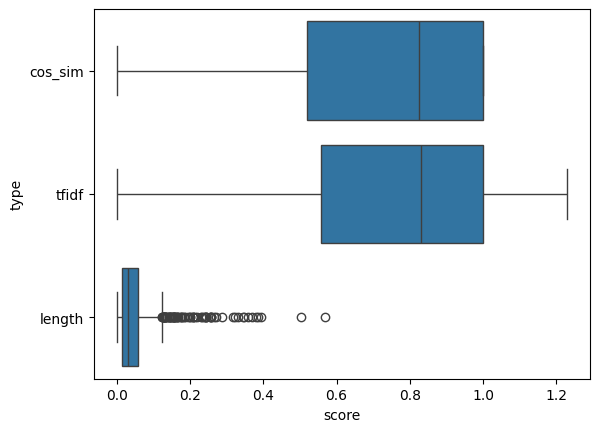

In [28]:
sns.boxplot(data=df_score[(df_score['type'] != 'tfidf_standart')], x="score", y="type")
plt.draw()

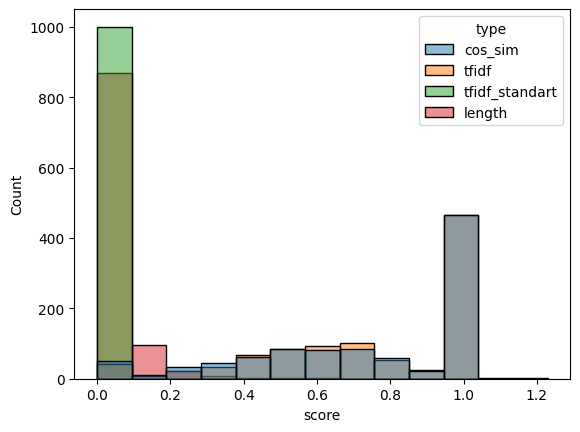

In [25]:
sns.histplot(data=df_score, x="score", hue="type")
plt.draw()

### Method 2 - G-Eval

In [29]:
model_name = 'mistralai/Mistral-7B-Instruct-v0.2'

In [30]:
geval_model = GEval(model_name=model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
score_lst = []
for i in tqdm(range(len(test_corpus))):
    review = test_corpus[i]
    score = geval_model.predict(review=review)
    score_lst.append(score)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
df_score = pd.DataFrame(data={'score': score_lst})

In [33]:
df_score.to_csv('df_score_geval.csv', index=False)

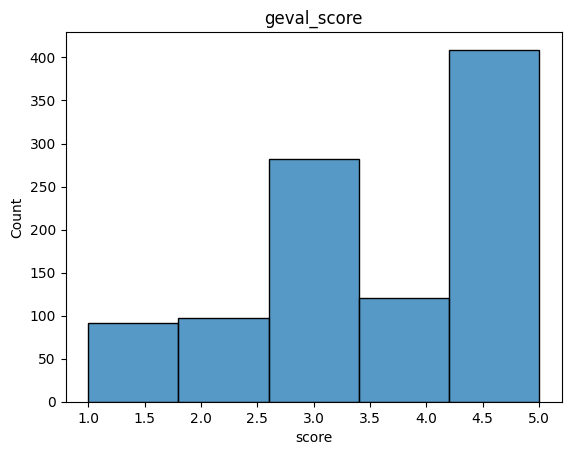

In [36]:
sns.histplot(data=df_score, x="score", bins=5)
plt.title("geval_score")
plt.draw()

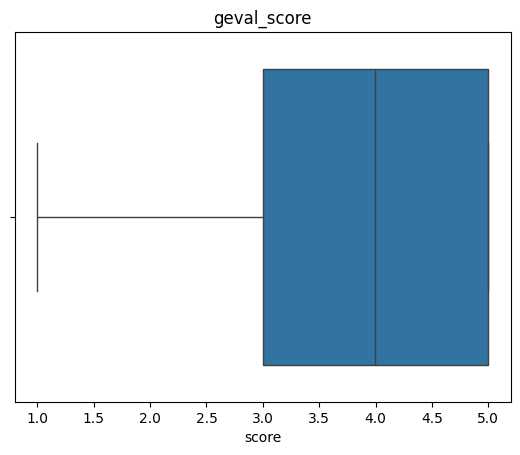

In [37]:
sns.boxplot(data=df_score, x="score")
plt.title("geval_score")
plt.draw()

### Сomparison Methods

In [161]:
df_score_geval = pd.read_csv("df_score_geval.csv")
df_score_tfidf_knn = pd.read_csv("df_score_tfidf_knn.csv")

In [162]:
df_score_tfidf_knn.head()

,score,type,index
0,0.590000,cos_sim,0
1,0.640000,tfidf,0
2,0.000364,tfidf_standart,0
3,0.058472,length,0
4,0.350000,cos_sim,1


In [155]:
df_ct = df_score_tfidf_knn[((df_score_tfidf_knn['type'] == 'cos_sim') | (df_score_tfidf_knn['type'] == 'tfidf'))]
uniq_index = list(df_ct[((df_ct['score'] == 0) | (df_ct['score'] == 1))]['index'].unique())
df_score_tfidf_knn = df_score_tfidf_knn[~df_score_tfidf_knn['index'].isin(uniq_index)]
df_score_geval = df_score_geval.loc[df_score_tfidf_knn['index'].unique()]

In [163]:
score_geval = list(df_score_geval['score'])
score_cos_sim = list(df_score_tfidf_knn[df_score_tfidf_knn['type'] == 'cos_sim']['score'])
score_tfidf = list(df_score_tfidf_knn[df_score_tfidf_knn['type'] == 'tfidf']['score'])
score_tfidf_standart = list(df_score_tfidf_knn[df_score_tfidf_knn['type'] == 'tfidf_standart']['score'])
score_length = list(df_score_tfidf_knn[df_score_tfidf_knn['type'] == 'length']['score'])

type_lst = ['score_geval']*len(score_geval) + ['cos_sim']*len(score_cos_sim) + ['score_tfidf']*len(score_tfidf) + ['score_tfidf_standart']*len(score_tfidf_standart) + ['score_length']*len(score_length)
score_lst = score_geval + score_cos_sim + score_tfidf + score_tfidf_standart + score_length
dict_scores = {'scores': score_lst, 'type_lst': type_lst}
dict_scores = {'score_geval': score_geval, 
               'score_cos_sim': score_cos_sim, 
               'score_tfidf': score_tfidf, 
               'score_tfidf_standart': score_tfidf_standart,
               'score_length': score_length}
df_scores = pd.DataFrame(data=dict_scores)

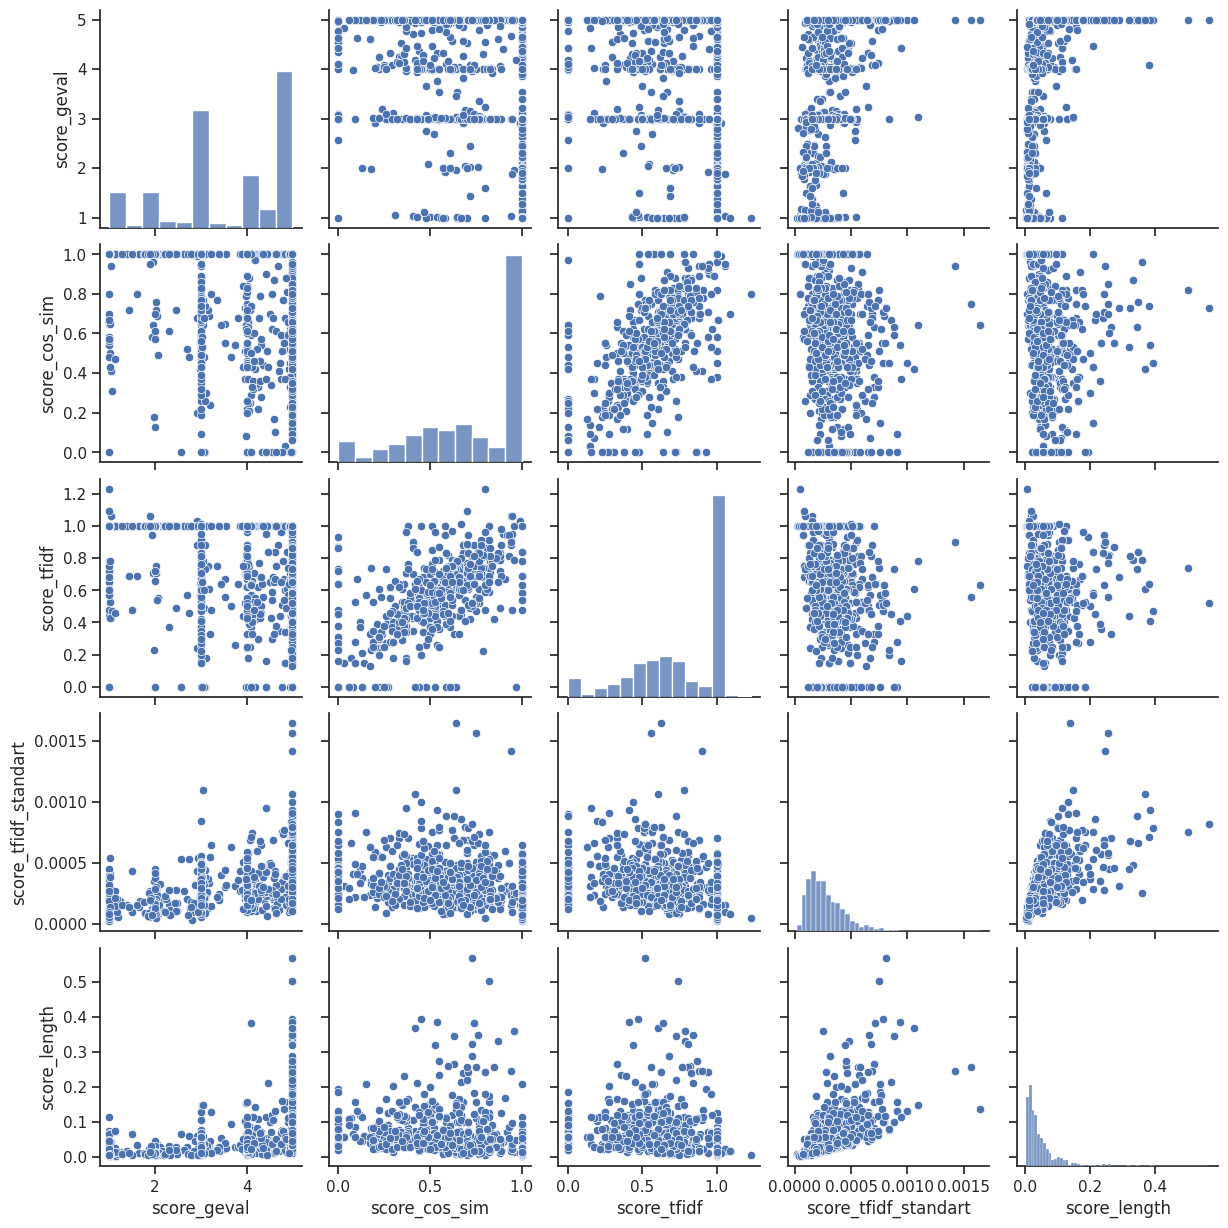

In [164]:
sns.set_theme(style="ticks")
sns.pairplot(df_scores)
plt.draw()

In [165]:
df_scores.corr()

,score_geval,score_cos_sim,score_tfidf,score_tfidf_standart,score_length
score_geval,1.000000,-0.394114,-0.367247,0.477837,0.462983
score_cos_sim,-0.394114,1.000000,0.870270,-0.428635,-0.356278
score_tfidf,-0.367247,0.870270,1.000000,-0.449564,-0.358477
score_tfidf_standart,0.477837,-0.428635,-0.449564,1.000000,0.661631
score_length,0.462983,-0.356278,-0.358477,0.661631,1.000000


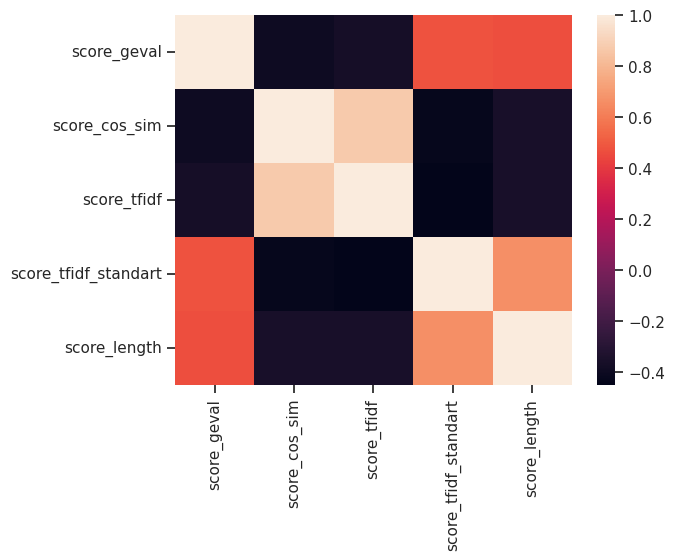

In [166]:
sns.heatmap(df_scores.corr()) 
plt.draw()

### Examples

In [172]:
df_score_geval = pd.read_csv("df_score_geval.csv")
df_score_tfidf_knn = pd.read_csv('df_score_tfidf_knn.csv')

In [173]:
eps = 0.001
dict_score_geval = {1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(len(df_score_geval)):
    score = df_score_geval.iloc[i]['score']
    for mark in dict_score_geval.keys():
        if mark - eps < score < mark + eps:
            dict_score_geval[mark].append(i)
            
for key, value in dict_score_geval.items():
    dict_score_geval[key] = random.sample(value, 2)

In [174]:
k = 5
dict_low_scores = {}
dict_top_scores = {}

for type_val in df_score_tfidf_knn['type'].unique():
    df_type = df_score_tfidf_knn[df_score_tfidf_knn['type'] == type_val]
    df_type = df_type.sort_values(by=['score'])
    low_index = list(df_type['index'].iloc[:k])
    top_index = list(df_type['index'].iloc[-k:])
    dict_low_scores[type_val] = low_index
    dict_top_scores[type_val] = top_index

In [175]:
def get_review_by_index(corpus: list[str], index_lst: list) -> list[str]:
    return np.array(corpus)[index_lst].tolist()

In [179]:
dict_eval = {}
for key, value in dict_score_geval.items():
    print('*'*100)
    print(f"G-Eval score - {key}")
    reviews = get_review_by_index(test_corpus, value)
        
    for i in range(len(value)):
        v = value[i]
        review = reviews[i]
        print('-'*50)
        print(review)
        print('-'*50)
        df_tf_scores = df_score_tfidf_knn[df_score_tfidf_knn['index'] == v]
        for type_val in df_tf_scores['type'].unique():
            tf_score = df_tf_scores[df_tf_scores['type'] == type_val]['score'].item()

            #print(f"type_val - {type_val}")
            #('{:f}'.format(tf_score))
            print(f"{type_val} - { ('{:f}'.format(tf_score))}")
            #print()
    print()

****************************************************************************************************
G-Eval score - 1
--------------------------------------------------
The book speaks for itself. One of the greatest works ever created. It is no wonder that Jane Austen and her novels are still revered today.
--------------------------------------------------
cos_sim - 1.000000
tfidf - 1.000000
tfidf_standart - 0.000129
length - 0.008666
--------------------------------------------------
I was very pleased. I received even better than I expected and it arrived timely.
--------------------------------------------------
cos_sim - 1.000000
tfidf - 1.000000
tfidf_standart - 0.000091
length - 0.005180

****************************************************************************************************
G-Eval score - 2
--------------------------------------------------
The idea is awsome as others have noted. However for the cost of the book, I was disapointed with the flaws in the gold leaf.